In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import re
from collections import Counter
import plotly.express as px
import json
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/pythonScripts")

from URL_helper import URL_helper

df = pd.read_csv('/Users/eugenganenco/Desktop/srealtyAnalysis/data/DataFile 16_11_2022_22_43/housesDf_17_11_2022_00_06_15.csv translatedWithCoordAndPrice.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None
np.seterr(divide = 'ignore') 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.shape)

(15552, 74)


In [2]:
df

link  \
0                https://www.sreality.cz/detail/prodej/dum/rodinny/skalna-skalna-chebska/4024649548   
1                          https://www.sreality.cz/detail/prodej/dum/rodinny/as-mokriny-/3592350044   
2                 https://www.sreality.cz/detail/prodej/dum/rodinny/cheb-podhrad-fialova/1913633116   
3                     https://www.sreality.cz/detail/prodej/dum/rodinny/plesna-lomnicka-/1159546700   
4      https://www.sreality.cz/detail/prodej/dum/rodinny/marianske-lazne-hamrniky-skolni/3745601884   
...                                                                                             ...   
15547                        https://www.sreality.cz/detail/prodej/dum/na-klic/vresina--/1481329244   
15548               https://www.sreality.cz/detail/prodej/dum/na-klic/ostrava-nova-bela-/2681559644   
15549            https://www.sreality.cz/detail/prodej/dum/na-klic/ostrava-hostalkovice-/1825921628   
15550         https://www.sreality.cz/detail/prodej/dum/na-klic/ostrava-moravska-ostrava-/896343388   
15551       https://www.sreality.cz/detail/prodej/dum/undefined/ostrava-hrabuvka-zavodni/3889243980   

                                              location district  \
0                                      Chebská, Skalná     cheb   
1                             Aš - Mokřiny, okres Cheb     cheb   
2                              Fialová, Cheb - Podhrad     cheb   
3                        Plesná - Lomnička, okres Cheb     cheb   
4                   Školní, Mariánské Lázně - Hamrníky     cheb   
...                                                ...      ...   
15547                     Vřesina, okres Ostrava-město  ostrava   
15548         Ostrava - Nová Bělá, okres Ostrava-město  ostrava   
15549      Ostrava - Hošťálkovice, okres Ostrava-město  ostrava   
15550  Ostrava - Moravská Ostrava, okres Ostrava-město  ostrava   
15551                      Závodní, Ostrava - Hrabůvka  ostrava   

                  HouseType                  total price  \
0            rodinne-domy\n   6 900 000 Kč za nemovitost   
1            rodinne-domy\n   2 990 000 Kč za nemovitost   
2            rodinne-domy\n   9 900 000 Kč za nemovitost   
3            rodinne-domy\n   4 590 000 Kč za nemovitost   
4            rodinne-domy\n  15 000 000 Kč za nemovitost   
...                     ...                          ...   
15547    projekty-na-klic\n                          NaN   
15548    projekty-na-klic\n                          NaN   
15549    projekty-na-klic\n                          NaN   
15550    projekty-na-klic\n   5 100 000 Kč za nemovitost   
15551  vicegeneracni-domy\n  15 900 000 Kč za nemovitost   

                                                                 Note on price  \
0      V případě více zájemců může RK využít pro výběr kupujícího formu aukce.   
1                                 včetně provize, právních i finančních služeb   
2                                 včetně provize, právních i finančních služeb   
3      V případě více zájemců může RK využít pro výběr kupujícího formu aukce.   
4                                                                          NaN   
...                                                                        ...   
15547                                                           cena u makléře   
15548                                                           cena u makléře   
15549                                                           cena u makléře   
15550                                                       provize se neplatí   
15551                                                                      NaN   

       Job ID      Update   Building      Object status Location of the house  \
0      817946       Včera    Cihlová              Dobrý            Samostatný   
1      N00400       Včera    Cihlová              Dobrý                Řadový   
2      N00318       Včera    Cihlová        Velmi dobrý            Samostatný   
3      819460       Vče

### Analysis of the dependent variable 'price'

Because of the way I collected the data, every time a row has the price equal zero means that there was no value found.

In [3]:
def percentageMissing(feature):
    missingValues = df[feature].apply(lambda x: 1 if pd.isna(x) else 0).sum()
    return round((missingValues/len(df.axes[0])) * 100, 3)

data = df.copy()
missingValues = data.price.apply(lambda x: 1 if x == 0 else 0).sum()
percentageOfDf = round((missingValues/len(df.axes[0])) * 100, 3)
print('There are {} missing values in the dependent variable column. {}% of the data frame.'.format(missingValues, percentageOfDf))

There are 1690 missing values in the dependent variable column. 10.867% of the data frame.


In [4]:
df = df.loc[df['price'] != 0]

I have eliminated all the instances where there was no value for the dependent variable.

In [5]:
print('Now the dependant variable has {}% missing.'.format(percentageMissing('price')))

Now the dependant variable has 0.0% missing.


In [6]:
print(f"Cheapest property found: {df['price'].min()} CZK")
print(f"Most expensive property found: {df['price'].max()} CZK")

Cheapest property found: 90000 CZK
Most expensive property found: 220000000 CZK


In [7]:
df.price.describe()

count    1.386200e+04
mean     7.387585e+06
std      7.240613e+06
min      9.000000e+04
25%      3.250000e+06
50%      5.490000e+06
75%      9.287500e+06
max      2.200000e+08
Name: price, dtype: float64

In [8]:
df.loc[df['price'] == df['price'].max(),['link', 'location']]

link  \
6321  https://www.sreality.cz/detail/prodej/dum/vila/praha-praha-4-/1187493452   

     location  
6321  Praha 4

In [9]:
df.loc[df['price'] == df['price'].min(),['link', 'location']]

link  \
15486  https://www.sreality.cz/detail/prodej/dum/rodinny/ostrava-radvanice-lipinska/278545996   

                            location  
15486  Lipinská, Ostrava - Radvanice

These are the most expensive and the cheapest properties on the market respectively.

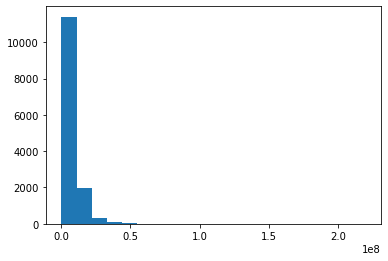

In [10]:
plt.hist(df['price'], bins=20)
plt.show()

The histogram above indicates a high degree of sqewness for the dependent variable. Could use some normalization.

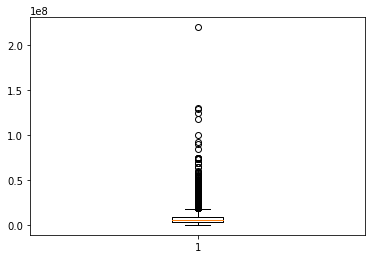

In [11]:
_ = plt.boxplot(df['price'])

We notice a lot of outliers.

In [12]:
def getOutliersList(feature):
    featureList = np.array(df[feature].tolist())
    featureList = featureList[~np.isnan(featureList)]
    upperQuartile = np.percentile(featureList, 75)
    lowerQuartile = np.percentile(featureList, 25)
    IQR = (upperQuartile - lowerQuartile) * 1.5
    resultList = []
    for observation in featureList:
        if observation >= upperQuartile + IQR or observation <= lowerQuartile - IQR:
            resultList.append(observation)
    return resultList

print(f"There are {len(getOutliersList('price'))} outliers in the 'price' column.")

There are 792 outliers in the 'price' column.


## Analysis of the independent variables

<AxesSubplot:>

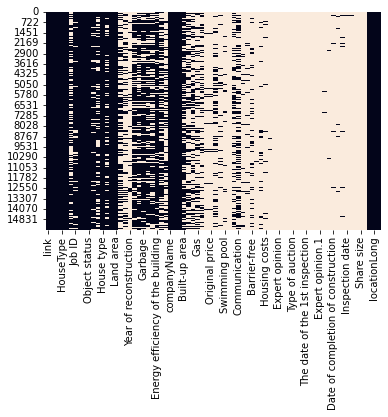

In [13]:
sns.heatmap(df.isnull(), cbar=False)

Many columns are very sparsely populated. Cells painted with beige are null.

In [14]:
data = df.copy()
featureList = []
for feature in data.columns:
    if percentageMissing(feature) >= 90:
        featureList.append(feature)
print('The following features have more than 90% missing data:\n')
print(featureList)    

The following features have more than 90% missing data:

['Discounted', 'Original price', 'Year of approval', 'Swimming pool', 'Cena', 'Indicator of energy efficiency of the building', 'Certificate of energy performance of the building', 'Ceiling height', 'ID', 'Housing costs', 'Number of flats', 'Starting price', 'Expert opinion', 'Minimum bid', 'Auction principal', 'Type of auction', 'Place of auction', 'The date of the auction', 'The date of the 1st inspection', 'The date of the 2nd inspection', 'Auction decree', 'Expert opinion.1', 'Pool area', 'Condition', 'Date of completion of construction', 'Soil construction', 'Sale start date', 'Inspection date', 'Inspection date to', 'Minimum purchase price', 'Share size', 'Number of owners']


### Relationship between missing variables and the dependent variable

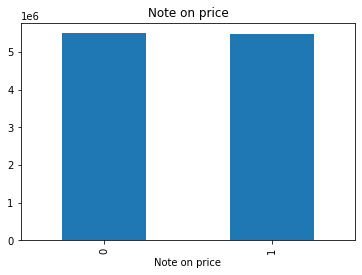

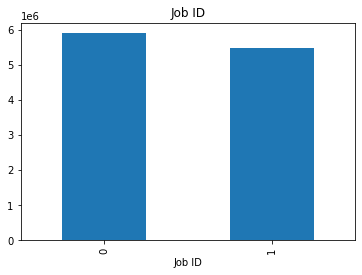

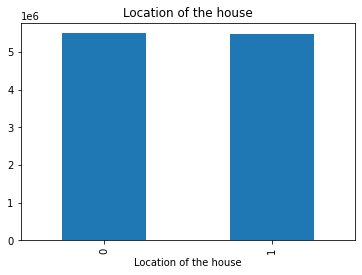

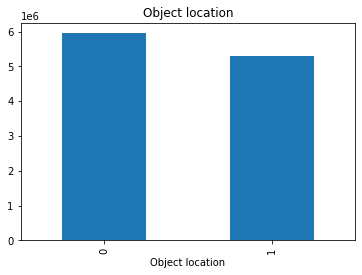

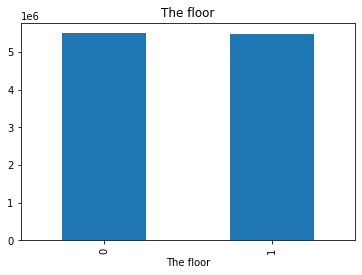

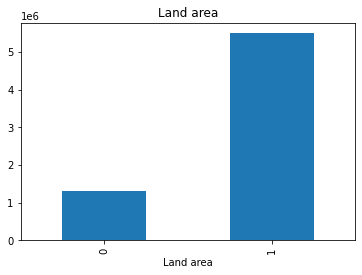

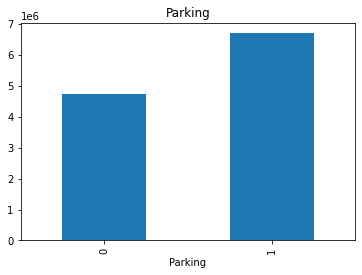

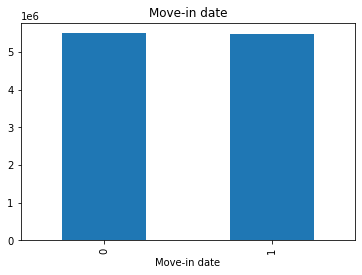

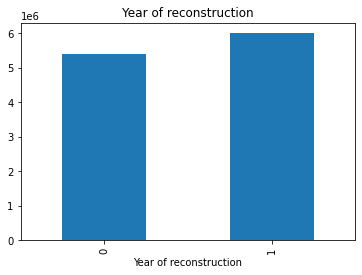

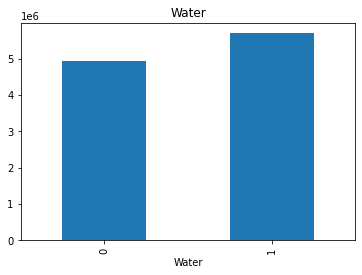

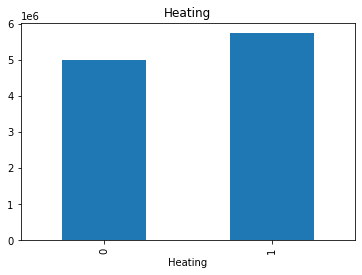

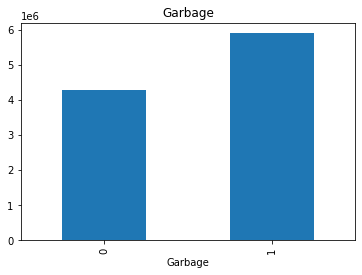

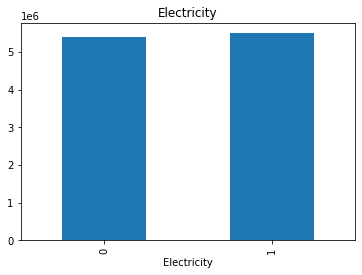

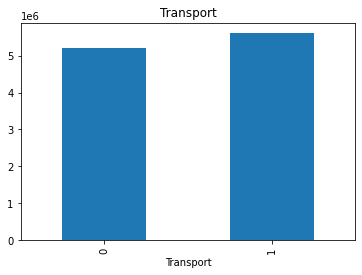

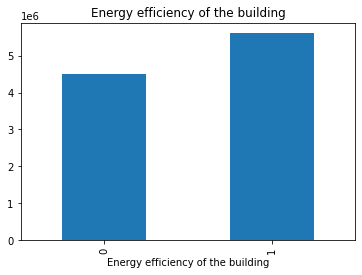

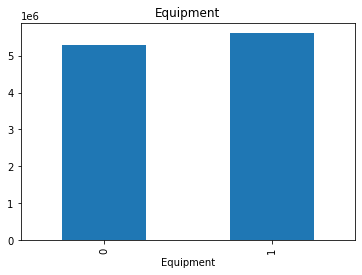

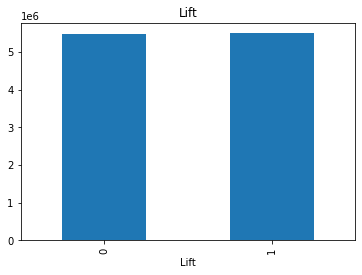

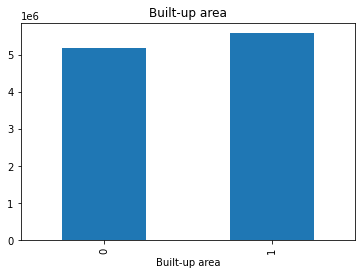

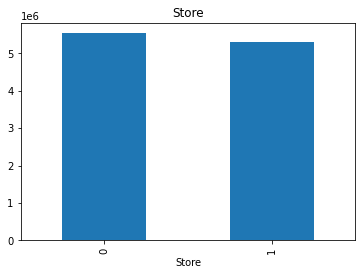

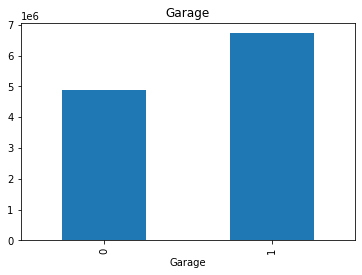

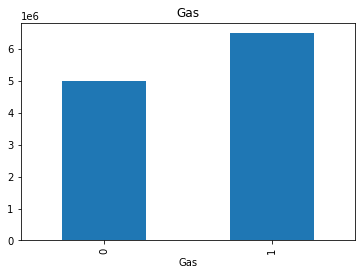

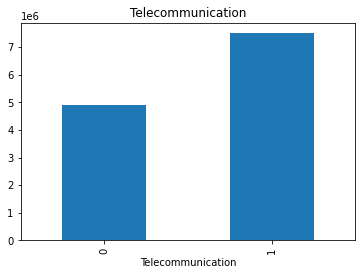

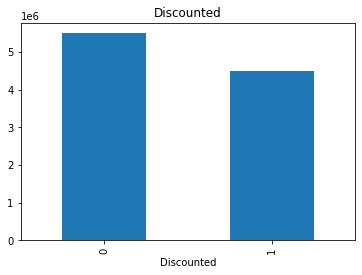

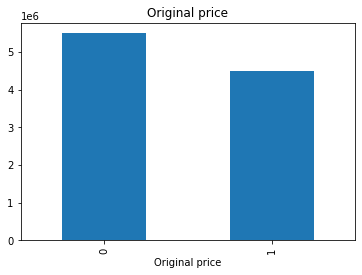

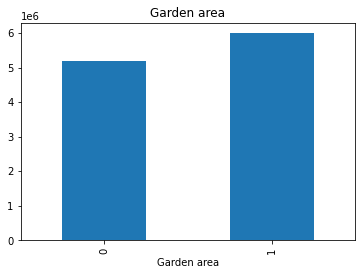

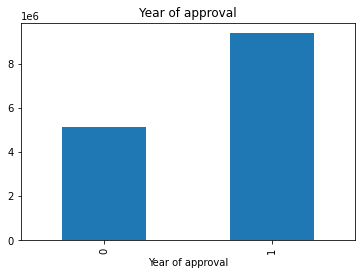

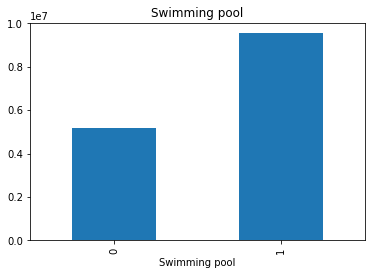

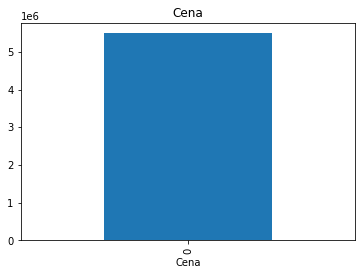

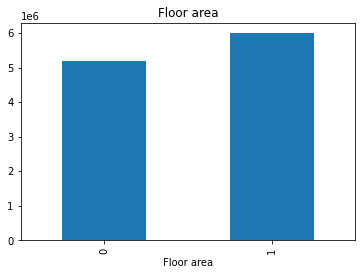

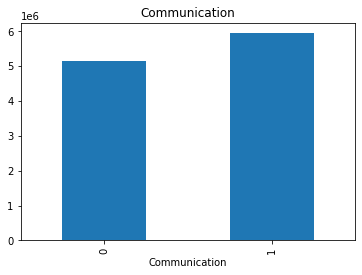

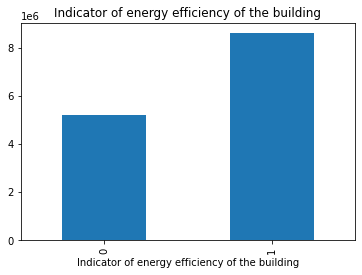

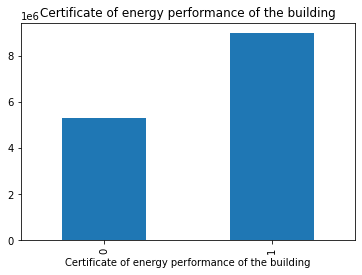

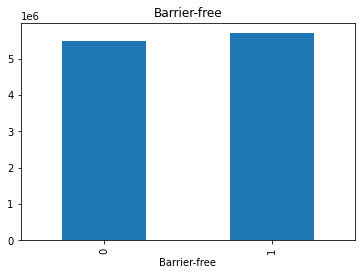

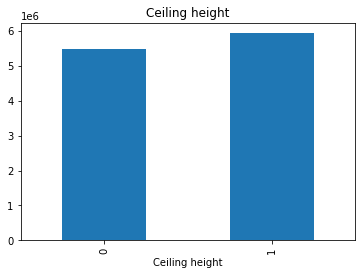

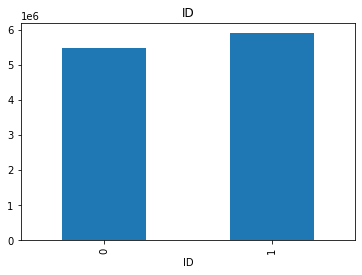

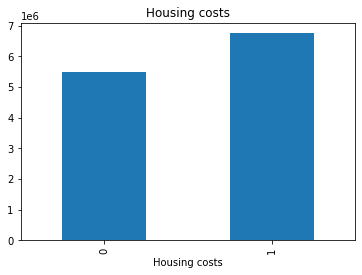

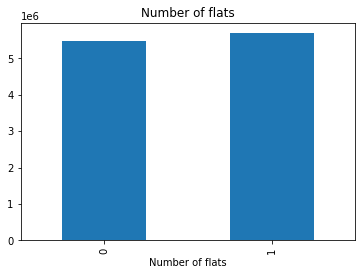

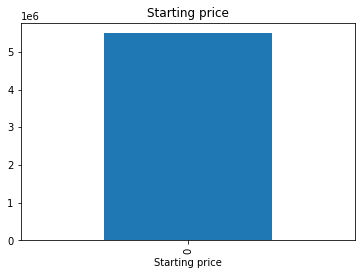

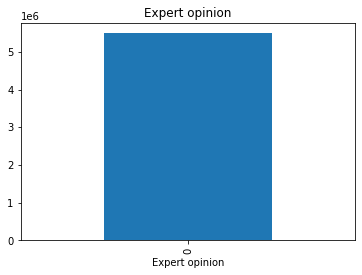

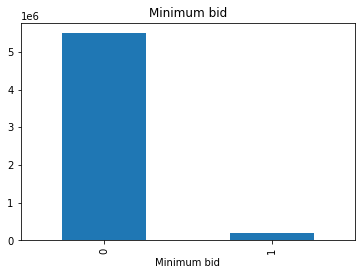

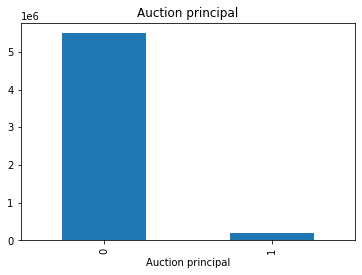

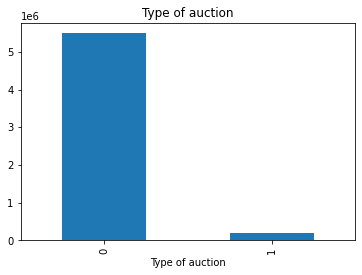

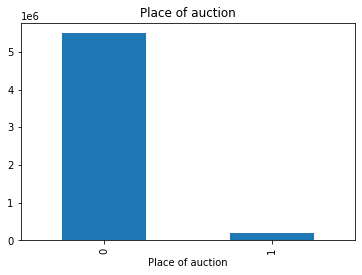

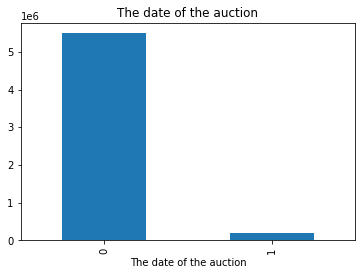

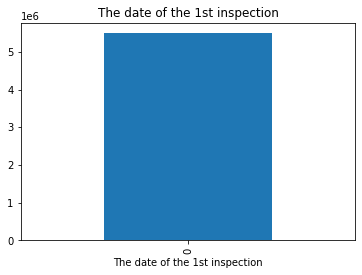

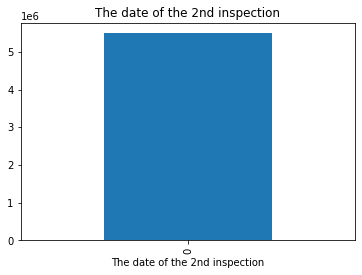

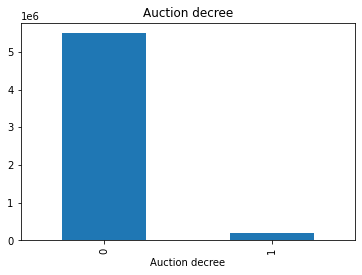

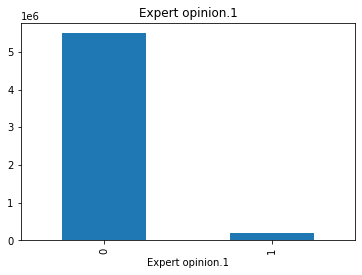

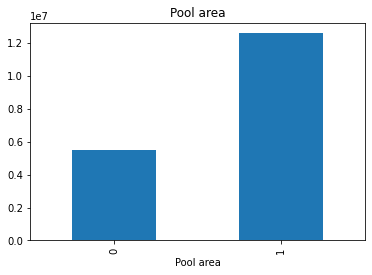

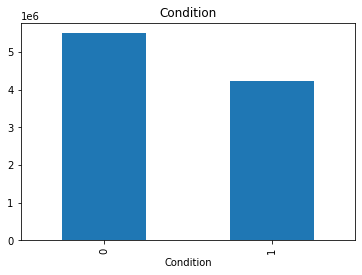

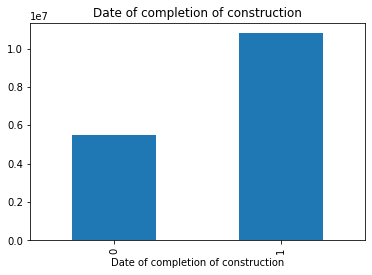

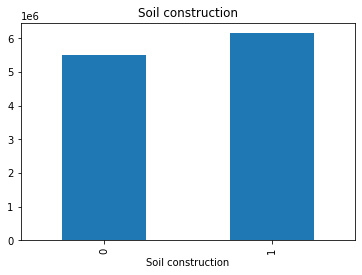

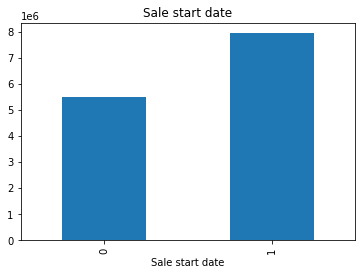

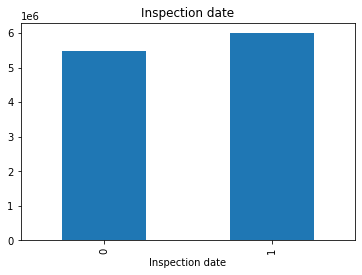

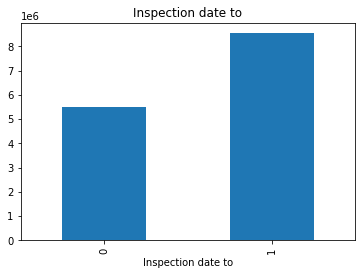

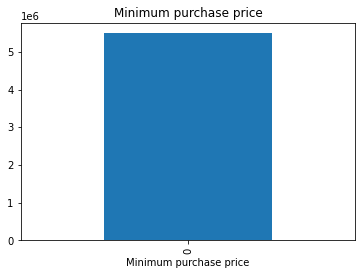

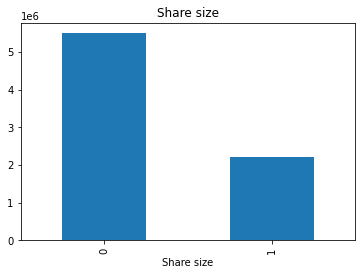

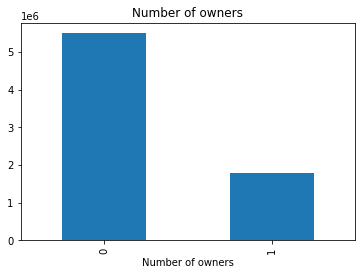

In [15]:
featuresWithMissing = [feature for feature in df.columns if df[feature].isnull().sum() > 1]
for feature in featuresWithMissing:
    data = df.copy()
    data[feature] = np.where(data[feature].notnull(), 1, 0)
    data.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()

There is a visible relationship between many of the missing values and the target variable. 

### Numerical variables

In [16]:
numbericalFeatures = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical features is: {} out of {}.'.format(len(numbericalFeatures), len(df.columns)))
df[numbericalFeatures].head(5)
for feature in numbericalFeatures:
    print('Percentage of missin values for "{}" variabel is: {}'.format(feature,percentageMissing(feature)))

Number of numerical features is: 13 out of 74.
Percentage of missin values for "Parking" variabel is: 55.915
Percentage of missin values for "Year of reconstruction" variabel is: 89.9
Percentage of missin values for "Lift" variabel is: 67.617
Percentage of missin values for "proximityIndex" variabel is: 0.0
Percentage of missin values for "Index" variabel is: 0.0
Percentage of missin values for "Garage" variabel is: 65.842
Percentage of missin values for "Year of approval" variabel is: 91.185
Percentage of missin values for "Swimming pool" variabel is: 93.147
Percentage of missin values for "Barrier-free" variabel is: 79.685
Percentage of missin values for "ID" variabel is: 91.61
Percentage of missin values for "Soil construction" variabel is: 98.586
Percentage of missin values for "Number of owners" variabel is: 99.986
Percentage of missin values for "price" variabel is: 0.0


### Relationship between year variables and price of houses

In [17]:
yearFeatures = [feature for feature in numbericalFeatures if 'yr' in feature.lower() or 'year' in feature.lower()]
print(yearFeatures)

['Year of reconstruction', 'Year of approval']


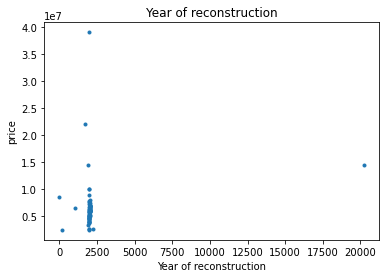

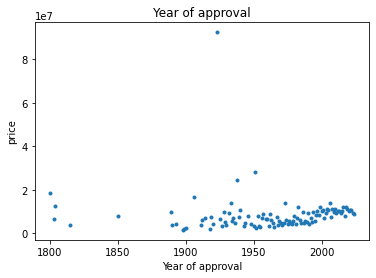

In [18]:
for feature in yearFeatures:
    df.groupby(feature)['price'].median().plot(style='.')
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

These are the graphs with year features containning outliers.

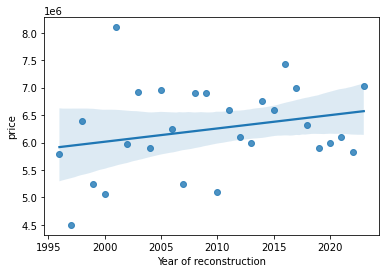

count     1400.000000
mean      2021.936429
std        493.029070
min          2.000000
25%       2010.000000
50%       2016.000000
75%       2020.000000
max      20221.000000
Name: Year of reconstruction, dtype: float64


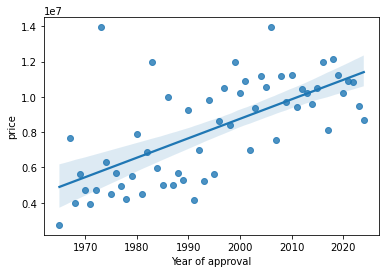

count    1222.000000
mean     2002.665303
std        29.398726
min      1800.000000
25%      1999.000000
50%      2013.000000
75%      2022.000000
max      2024.000000
Name: Year of approval, dtype: float64


In [19]:
for feature in yearFeatures:
    outlierList = getOutliersList(feature)
    featureSeries = df.loc[~df[feature].isin(outlierList), :].groupby(feature)['price'].median()
    sns.regplot(x=featureSeries.index, y=featureSeries)
    plt.show()
    print(df[feature].describe())

These are the graphs we get when we eliminate the outliers.

### Discrete variables

In [20]:
discreteVariables = [feature for feature in numbericalFeatures if len(df[feature].unique()) < 30 and len(df[feature].unique()) > 1 and feature not in yearFeatures]
print(discreteVariables)

['Lift', 'Swimming pool', 'Barrier-free', 'Soil construction', 'Number of owners']


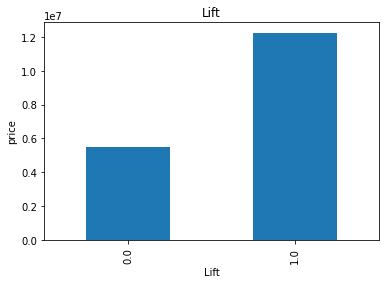

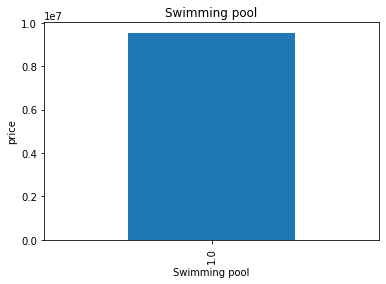

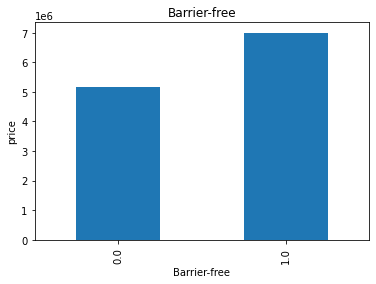

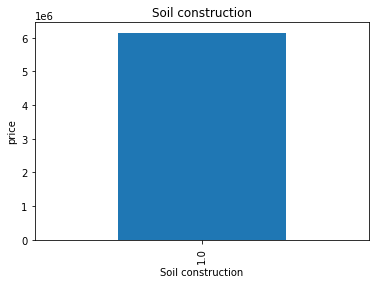

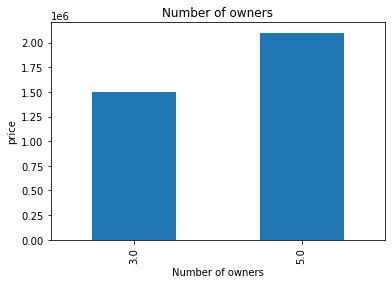

In [21]:
for feature in discreteVariables:
    data = df.copy()
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Continuous features

In [22]:
continuousFeatures = [feature for feature in numbericalFeatures if feature not in discreteVariables + yearFeatures + ['Index', 'ID', 'price']]
print(continuousFeatures)

['Parking', 'proximityIndex', 'Garage']


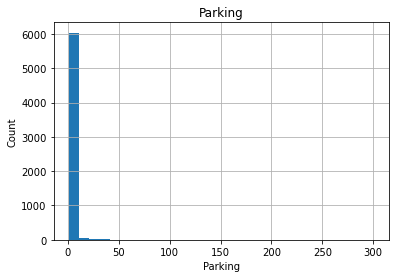

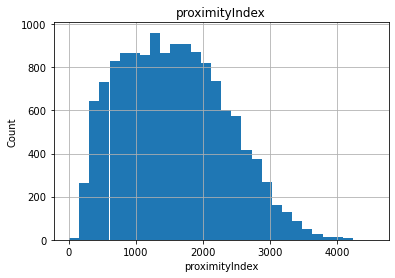

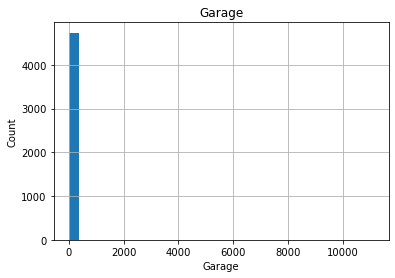

In [23]:
for feature in continuousFeatures:
    data = df.copy()
    data[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

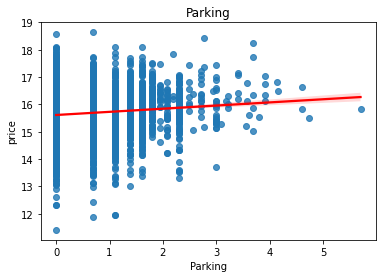

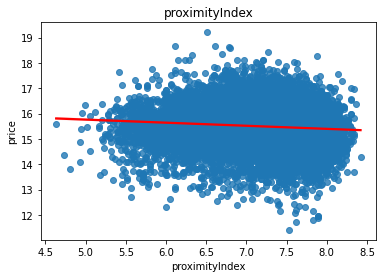

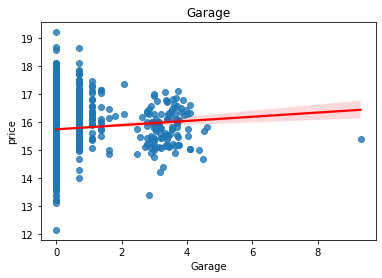

In [24]:
for feature in continuousFeatures:
    data = df.copy()
    data[feature] = np.log(data.loc[data[feature] != 0, feature])
    data['price'] = np.log(data['price'])
    sns.regplot(x=data[feature], y=data['price'], line_kws={"color": "red"})
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Categorical features

In [25]:
categoricalFeatures = [feature for feature in df.columns if df[feature].dtypes == 'O']
print(categoricalFeatures)

['link', 'location', 'district', 'HouseType', 'total price', 'Note on price', 'Job ID', 'Update', 'Building', 'Object status', 'Location of the house', 'Object location', 'House type', 'The floor', 'Usable area', 'Land area', 'Move-in date', 'Water', 'Heating', 'Garbage', 'Electricity', 'Transport', 'Energy efficiency of the building', 'Equipment', 'companyName', 'Built-up area', 'Store', 'Gas', 'Telecommunication', 'Discounted', 'Original price', 'Garden area', 'Cena', 'Floor area', 'Communication', 'Indicator of energy efficiency of the building', 'Certificate of energy performance of the building', 'Ceiling height', 'Housing costs', 'Number of flats', 'Starting price', 'Expert opinion', 'Minimum bid', 'Auction principal', 'Type of auction', 'Place of auction', 'The date of the auction', 'The date of the 1st inspection', 'The date of the 2nd inspection', 'Auction decree', 'Expert opinion.1', 'Pool area', 'Condition', 'Date of completion of construction', 'Sale start date', 'Inspectio

In [26]:
for feature in categoricalFeatures:
    print('The feature is "{}". Number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is "link". Number of categories are 13862
The feature is "location". Number of categories are 9419
The feature is "district". Number of categories are 86
The feature is "HouseType". Number of categories are 8
The feature is "total price". Number of categories are 3004
The feature is "Note on price". Number of categories are 2186
The feature is "Job ID". Number of categories are 11876
The feature is "Update". Number of categories are 212
The feature is "Building". Number of categories are 7
The feature is "Object status". Number of categories are 10
The feature is "Location of the house". Number of categories are 5
The feature is "Object location". Number of categories are 8
The feature is "House type". Number of categories are 2
The feature is "The floor". Number of categories are 70
The feature is "Usable area". Number of categories are 796
The feature is "Land area". Number of categories are 2950
The feature is "Move-in date". Number of categories are 63
The feature is "W

['HouseType', 'Building', 'Object status', 'Location of the house', 'Object location', 'House type', 'Water', 'Garbage', 'Electricity', 'Energy efficiency of the building', 'Equipment', 'Gas', 'Certificate of energy performance of the building', 'Number of flats', 'Minimum bid', 'Auction principal', 'Type of auction', 'Place of auction', 'The date of the auction', 'Auction decree', 'Expert opinion.1', 'Condition', 'Inspection date to', 'Share size']
  
  
['HouseType', 'Building', 'Object status', 'Location of the house', 'Object location', 'House type', 'Water', 'Garbage', 'Electricity', 'Energy efficiency of the building', 'Equipment', 'Gas', 'Certificate of energy performance of the building']


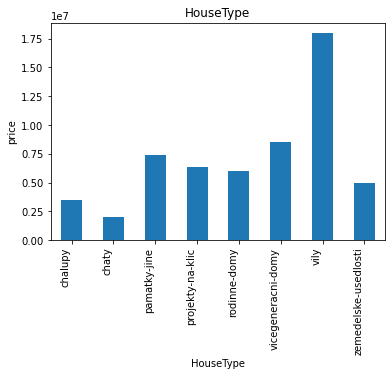

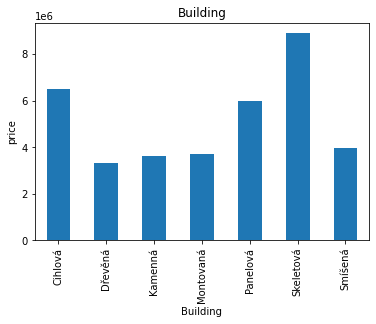

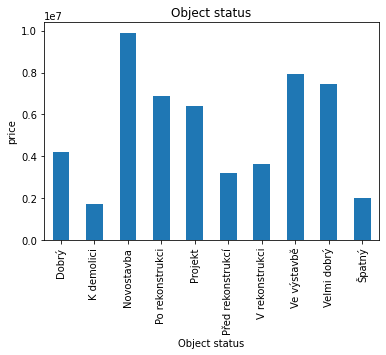

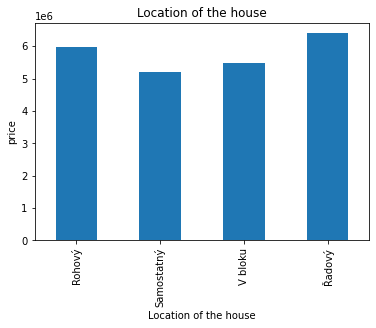

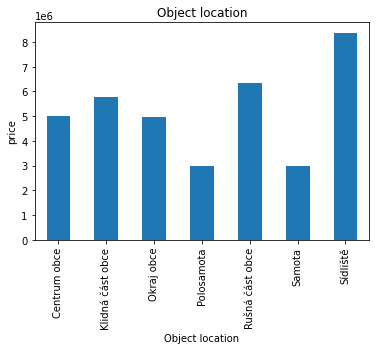

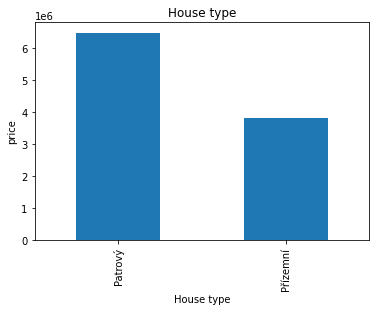

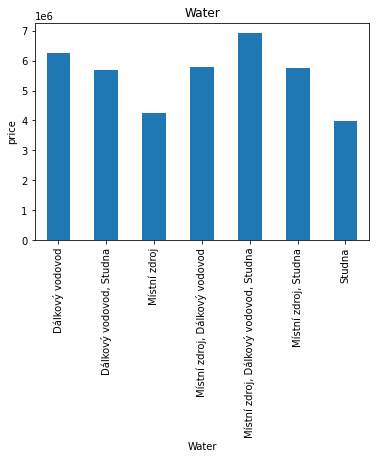

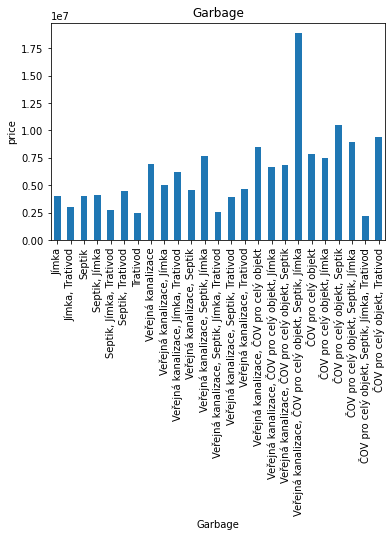

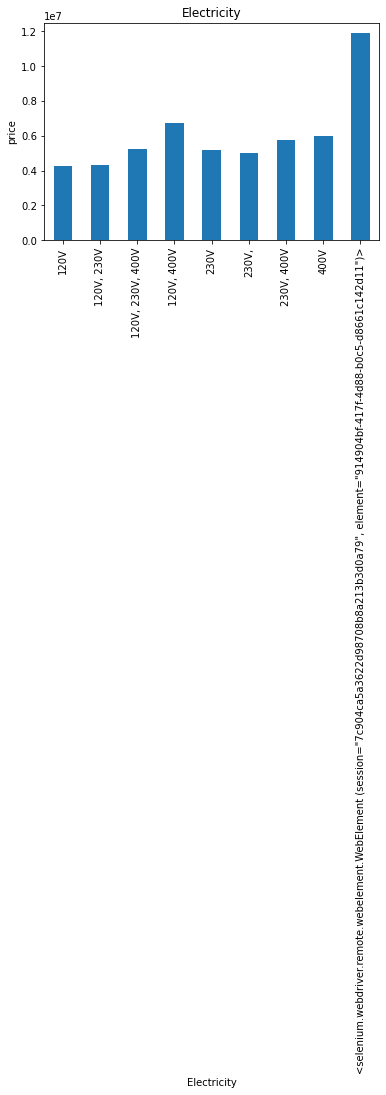

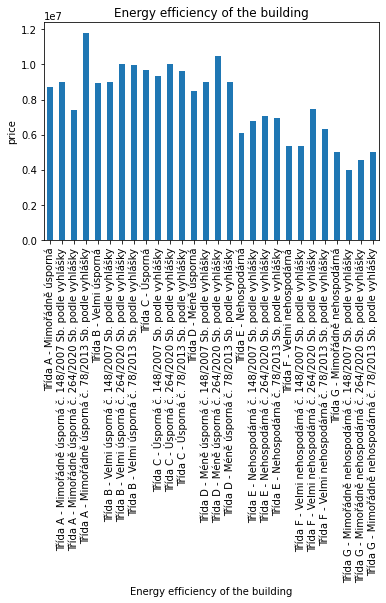

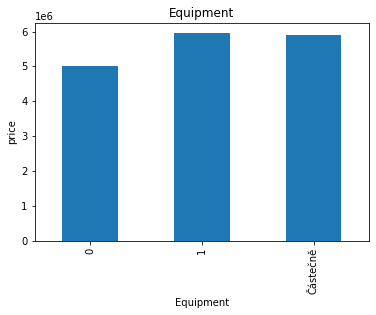

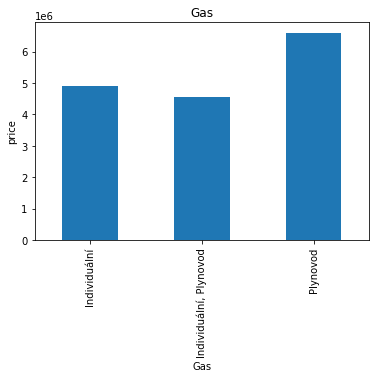

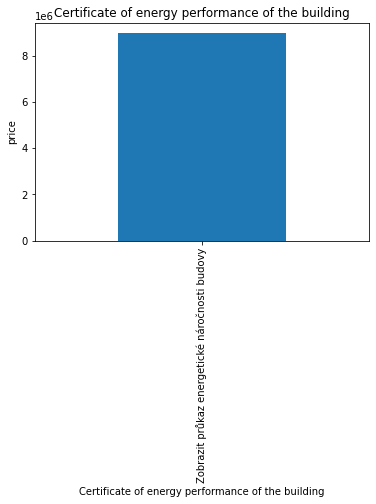

In [27]:
data = df.copy()
categoricalFeatures = [feature for feature in categoricalFeatures if len(data[feature].unique()) <= 30 and len(data[feature].unique()) > 1]
print(categoricalFeatures)
categoricalFeatures = categoricalFeatures[:-11]
print('  ')
print('  ')
print(categoricalFeatures)
for feature in categoricalFeatures:
    data.groupby(feature)['price'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### Map of the Czech Republic with the average price of property being sold per NUTS 4 region.

In [28]:
czechStates = json.load(open('geoJsonCZ.json', 'r'))
czechStates['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[14.56924461704827, 50.00770879957661],
    [14.534995811950823, 50.0114772445781],
    [14.393345768303185, 49.952517282092586],
    [14.345847384894167, 49.94727171895303],
    [14.33880567277518, 49.98049139096107],
    [14.296061152888404, 50.002024441137266],
    [14.271127862446134, 50.03965596360334],
    [14.25937514380102, 50.10043274550602],
    [14.316258327373454, 50.12839885596487],
    [14.359078279683196, 50.11598765248309],
    [14.365589647853326, 50.1481991545729],
    [14.401072379953709, 50.1479349371616],
    [14.46673359236424, 50.16938602301883],
    [14.533544563410173, 50.17686790571296],
    [14.610808414188728, 50.12667002763059],
    [14.658801088509474, 50.12282344095549],
    [14.665945478445733, 50.103183216955685],
    [14.706571427483144, 50.08722630297063],
    [14.641226225810158, 50.05720943085254],
    [14.66919214143369, 50.01927774803277],
    [14.640195000385926, 50.005843552

In [29]:
czechLocationsMap = {}
for feature in czechStates['features']:
    feature['id'] = feature['properties']['NUTS4']
    czechLocationsMap[feature['properties']['name']] = feature['id']

In [30]:
locationsSet = URL_helper().getLocationsSet()
locationsSet.remove('praha')
locationsSet.add('praha')

In [31]:
czechLocationsMap = {}
for feature in czechStates['features']:
    feature['id'] = feature['properties']['NUTS4']
    czechLocationsMap[feature['properties']['name']] = feature['id']

def findCorrespondingString(string, stringSet):
    if 'město' in string:
        string = string.replace('-město', '$')
    if ' n.' in string:
        string = string.replace(' n.', '-nad-') 
    charList = ['^']
    reg = re.compile(r'[a-zA-Z-]')
    for c in string:
        if c == '$':
            if charList[-1] == '*':
                charList = charList[0:len(charList)-1]
            break
        if reg.match(c):
            charList.append(c)
        else:
            charList.append('.')
            charList.append('*')
    if charList[-1] != '$':
        charList.append('$')
    string = ''.join(charList).lower()
    reg = re.compile(string)
    for s in stringSet:
        if reg.search(s.lower()):
            return s
    return 'Unknown'

for location in list(czechLocationsMap):
    # map location to the corresponding one in df
    val = czechLocationsMap[location]
    czechLocationsMap.pop(location)
    location = findCorrespondingString(location, locationsSet)
    czechLocationsMap[location] = val
    
print(czechLocationsMap)
print(len(locationsSet))

{'praha': 'CZ0110', 'benesov': 'CZ0211', 'beroun': 'CZ0212', 'kladno': 'CZ0213', 'kolin': 'CZ0214', 'kutna-hora': 'CZ0215', 'melnik': 'CZ0216', 'mlada-boleslav': 'CZ0217', 'nymburk': 'CZ0218', 'praha-vychod': 'CZ0219', 'praha-zapad': 'CZ021A', 'pribram': 'CZ021B', 'rakovnik': 'CZ021C', 'ceske-budejovice': 'CZ0311', 'cesky-krumlov': 'CZ0312', 'jindrichuv-hradec': 'CZ0313', 'pelhrimov': 'CZ0613', 'pisek': 'CZ0314', 'prachatice': 'CZ0315', 'strakonice': 'CZ0316', 'tabor': 'CZ0317', 'domazlice': 'CZ0321', 'cheb': 'CZ0411', 'karlovy-vary': 'CZ0412', 'klatovy': 'CZ0322', 'plzen': 'CZ0323', 'plzen-jih': 'CZ0324', 'plzen-sever': 'CZ0325', 'rokycany': 'CZ0326', 'sokolov': 'CZ0413', 'tachov': 'CZ0327', 'ceska-lipa': 'CZ0511', 'decin': 'CZ0421', 'chomutov': 'CZ0422', 'jablonec-nad-nisou': 'CZ0512', 'liberec': 'CZ0513', 'litomerice': 'CZ0423', 'louny': 'CZ0424', 'most': 'CZ0425', 'teplice': 'CZ0426', 'usti-nad-labem': 'CZ0427', 'havlickuv-brod': 'CZ0611', 'hradec-kralove': 'CZ0521', 'chrudim': 'CZ

In [32]:
df['id'] = df['district'].apply(lambda x: czechLocationsMap['praha'] if bool(re.search(r'\d', x)) else czechLocationsMap[x])
len(df['id'].unique())

77

In [33]:
data = df.groupby('id')['price'].apply(np.average)
data = data.to_frame()
data['N4'] = data.index
czechLocationsMapInversed = {v: k for k, v in czechLocationsMap.items()}
data['locationName'] = data['N4'].map(czechLocationsMapInversed)
data['Most Frequent House Type'] = df.groupby('id')['HouseType'].agg(pd.Series.mode)
data['Most Prevalent Company'] = df.groupby('id')['companyName'].agg(pd.Series.mode)
fig = px.choropleth(data, locations='N4', geojson=czechStates, color='price', hover_name='locationName', 
                   hover_data = ['Most Frequent House Type', 'Most Prevalent Company'])
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

In [34]:
data

price      N4   locationName Most Frequent House Type  \
id                                                                     
CZ0110  2.151945e+07  CZ0110          praha           rodinne-domy\n   
CZ0211  7.272097e+06  CZ0211        benesov           rodinne-domy\n   
CZ0212  1.036524e+07  CZ0212         beroun           rodinne-domy\n   
CZ0213  8.472392e+06  CZ0213         kladno           rodinne-domy\n   
CZ0214  7.259334e+06  CZ0214          kolin           rodinne-domy\n   
...              ...     ...            ...                      ...   
CZ0812  5.733642e+06  CZ0812  frydek-mistek           rodinne-domy\n   
CZ0813  5.003005e+06  CZ0813        karvina           rodinne-domy\n   
CZ0814  4.780787e+06  CZ0814     novy-jicin           rodinne-domy\n   
CZ0815  4.995726e+06  CZ0815          opava           rodinne-domy\n   
CZ0816  7.090167e+06  CZ0816        ostrava           rodinne-domy\n   

                  Most Prevalent Company  
id                                        
CZ0110                       M&M reality  
CZ0211                       M&M reality  
CZ0212                       M&M reality  
CZ0213  [M&M reality, RE/MAX G8 Reality]  
CZ0214                 RE/MAX G8 Reality  
...                                  ...  
CZ0812                       M&M reality  
CZ0813                       M&M reality  
CZ0814                       M&M reality  
CZ0815                       M&M reality  
CZ0816                       M&M reality  

[77 rows x 5 columns]

<AxesSubplot:>

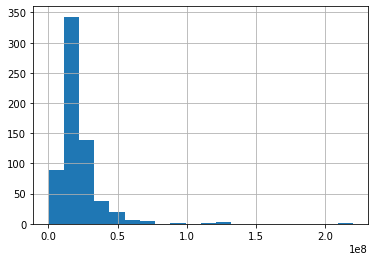

In [35]:
df.loc[df.id == 'CZ0110', 'price'].hist(bins=20)

Price distribution of properties sold in Prague.

companyName
M&M reality                10549338503
Broker Consulting, a.s.     2541745423
Bidli                       2216967550
RE/MAX G8 Reality           1506216824
Svoboda & Williams          1416111740
Other Companies            84176316604
Name: price, dtype: int64


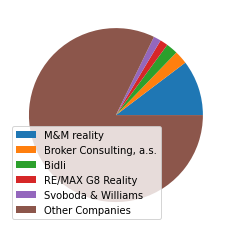

In [36]:
totalValueSeries = df.groupby('companyName')['price'].sum().sort_values(ascending=False)
valueCompanies = totalValueSeries.head(5)
otherCompanies = totalValueSeries.tail(totalValueSeries.count() - 5).sum()
valueCompanies.loc['Other Companies'] = otherCompanies
print(valueCompanies)
plt.pie(valueCompanies)
plt.legend(valueCompanies.index, loc='best')
plt.show()

In [37]:
totalValueSeries.sum()

102406696644

These are the top companies in Czech Republic by the total value of the properties they are selling.

companyName
M&M reality                1797
Broker Consulting, a.s.     327
Bidli                       301
RE/MAX G8 Reality           255
Realitní kancelář STING     170
Name: link, dtype: int64


<AxesSubplot:xlabel='companyName'>

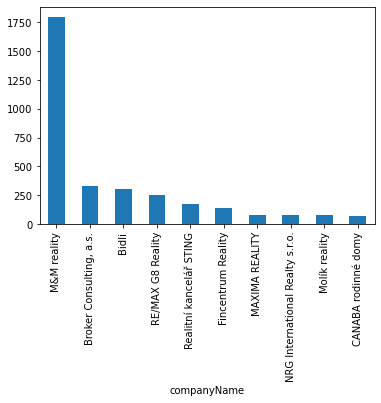

In [38]:
countSeries = df.groupby('companyName')['link'].count().sort_values(ascending=False)
print(countSeries.head(5))
countSeries.head(10).plot.bar()

These are the top companies in Czech Republic by the number of the houses they are selling (assuming that every posting refers to a different property).

In [39]:
companiesDF = pd.concat([totalValueSeries, countSeries], axis=1)
companiesDF['AveragePrice'] = companiesDF.iloc[:,0] / companiesDF.iloc[:,1]
companiesDF[companiesDF.iloc[:,1] >= 10]['AveragePrice'].sort_values(ascending=False)

companyName
TL Real                                     3.484547e+07
Y&T Luxury Property – luxusní byty Praha    3.374200e+07
ENGEL & VÖLKERS                             2.889800e+07
AMBIENTEN VIP                               2.799955e+07
Lexxus Norton                               2.634917e+07
                                                ...     
Krása bydlení                               2.575909e+06
AURA reality                                2.534211e+06
Realitní a finanční kancelář Králik         2.409091e+06
MI Estate                                   2.318692e+06
NEXT REALITY O-CITY                         2.164167e+06
Name: AveragePrice, Length: 266, dtype: float64

These are top companies in Czech Republic, that have at least 10 houses on the market, by the average price of the property they are selling.

In [40]:
companiesDF

price  link  AveragePrice
companyName                                                               
M&M reality                                10549338503  1797  5.870528e+06
Broker Consulting, a.s.                     2541745423   327  7.772922e+06
Bidli                                       2216967550   301  7.365341e+06
RE/MAX G8 Reality                           1506216824   255  5.906733e+06
Svoboda & Williams                          1416111740    61  2.321495e+07
...                                                ...   ...           ...
Ing. Václav Koubek                              435000     1  4.350000e+05
Stanislav Čedík - Česká realitní kancelář       430000     1  4.300000e+05
REMEDIANTE                                      350000     1  3.500000e+05
REALITY KRKONOŠE                                300000     1  3.000000e+05
Dražbyprost                                     186200     1  1.862000e+05

[2288 rows x 3 columns]

In [41]:
companiesDF = companiesDF.rename(columns = {'price':'sumValOfProperties'})
companiesDF = companiesDF.rename(columns = {'link':'count'})

In [42]:
totalMarketValue = companiesDF['sumValOfProperties'].sum()
companiesDF['share'] = companiesDF['sumValOfProperties'] / totalMarketValue

In [43]:
totalMarketValue

102406696644

In [44]:
companiesDF['share']

companyName
M&M reality                                  0.103014
Broker Consulting, a.s.                      0.024820
Bidli                                        0.021649
RE/MAX G8 Reality                            0.014708
Svoboda & Williams                           0.013828
                                               ...   
Ing. Václav Koubek                           0.000004
Stanislav Čedík - Česká realitní kancelář    0.000004
REMEDIANTE                                   0.000003
REALITY KRKONOŠE                             0.000003
Dražbyprost                                  0.000002
Name: share, Length: 2288, dtype: float64

In [45]:
def findHHI(shareSeries):
    return 10000*((shareSeries**2).sum())

print(findHHI(companiesDF['share']))

132.99735329240298


Region          House Type          HHI  Number of Properties  \
188  CZ0217  projekty-na-klic\n  7656.315726                    12   
500  CZ0712  projekty-na-klic\n  7448.023962                    18   
460  CZ0622  projekty-na-klic\n  6497.234956                    11   
548  CZ0722  projekty-na-klic\n  5048.324042                    15   
540  CZ0721  projekty-na-klic\n  4846.133237                    13   
131  CZ0422             chaty\n  4504.073795                    23   
42   CZ0325           chalupy\n  4417.903596                    14   
348  CZ0532  projekty-na-klic\n  3430.222923                    15   
564  CZ0724  projekty-na-klic\n  3378.222181                    20   
58   CZ0324           chalupy\n  3262.630279                    11   
35   CZ0326             chaty\n  3212.475525                    21   
19   CZ0413             chaty\n  2734.750135                    13   
74   CZ0321           chalupy\n  2715.137423                    11   
212  CZ021A  projekty-na-klic\n  2601.780238                    13   
490  CZ0627           chalupy\n  2567.137425                    12   

                 Name  
188    mlada-boleslav  
500           olomouc  
460              brno  
548  uherske-hradiste  
540          kromeriz  
131          chomutov  
42        plzen-sever  
348         pardubice  
564              zlin  
58          plzen-jih  
35           rokycany  
19            sokolov  
74          domazlice  
212       praha-zapad  
490            znojmo

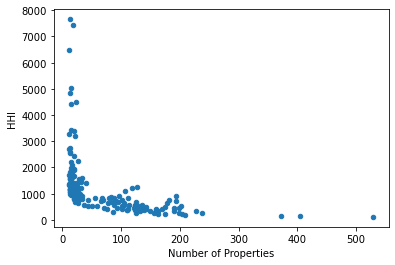

In [46]:
def calculateShare(marketDF):
    total = marketDF['price'].sum()
    marketDF = marketDF.groupby(['companyName'], as_index=False)['price'].sum()
    marketDF['share'] = marketDF['price'] / total
    return marketDF

regionList = df['id'].unique()
houseTypeList = df['HouseType'].unique()
marketDF = pd.DataFrame()
for region in regionList:
    for houseType in houseTypeList:
        tempDF = df.loc[(df['HouseType'] == houseType) & (df['id'] == region), ['price', 'companyName']]
        houseNum = len(tempDF.index)
        tempDF = calculateShare(tempDF)
        hhi = findHHI(tempDF['share'])
        row = {'Region' : region, 'House Type' : houseType, 'HHI' : hhi, 'Number of Properties': houseNum}
        rowDF = pd.DataFrame([row])
        marketDF = pd.concat([marketDF, rowDF], axis=0, ignore_index=True)
        
marketDF = marketDF.loc[marketDF['Number of Properties'] > 10, :].sort_values('HHI', ascending=False)
marketDF.plot.scatter(x = 'Number of Properties', y = 'HHI')
marketDF['Name'] = marketDF['Region'].map(czechLocationsMapInversed)
marketDF = marketDF.loc[marketDF['HHI'] > 2500,:]
marketDF

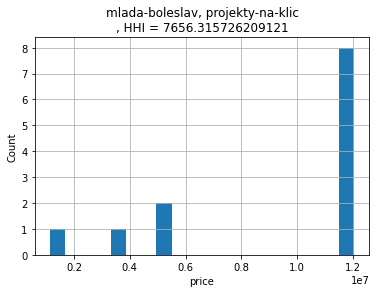

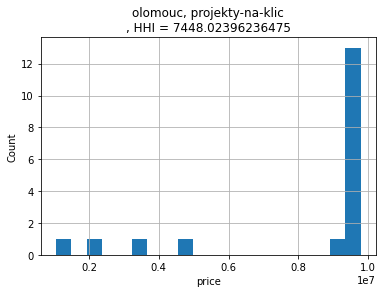

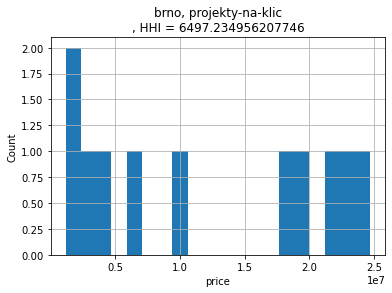

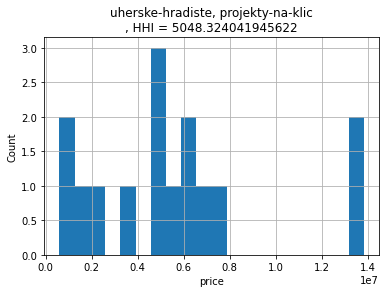

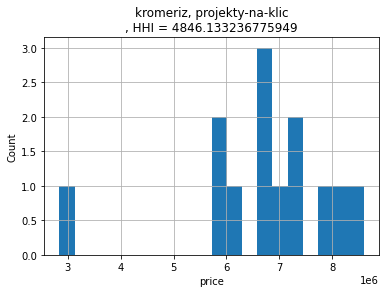

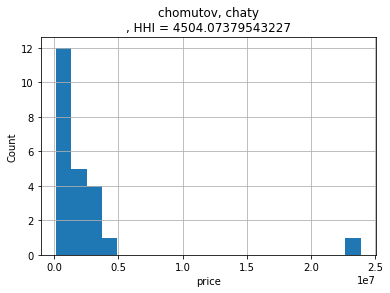

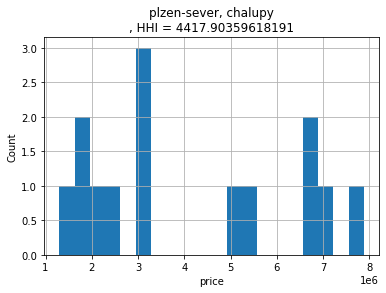

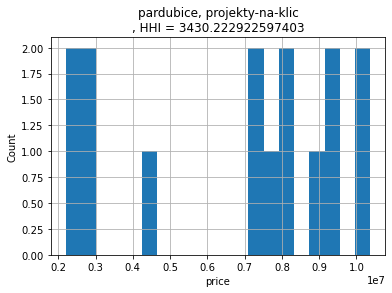

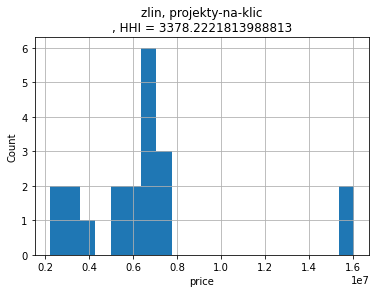

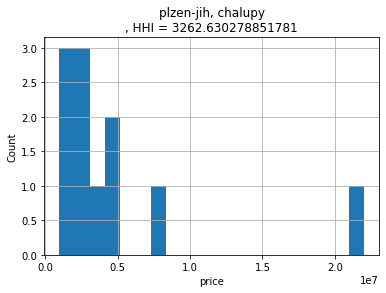

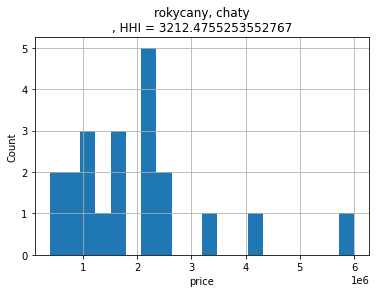

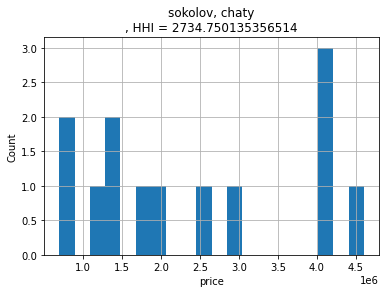

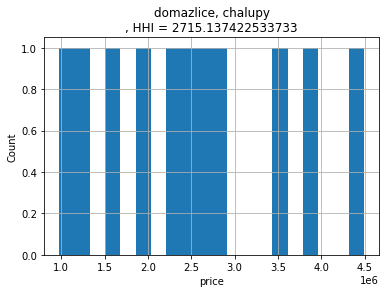

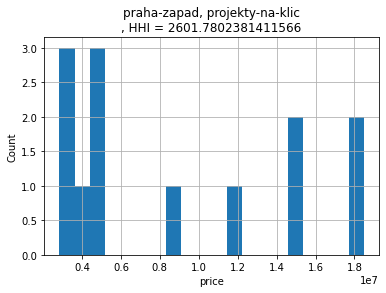

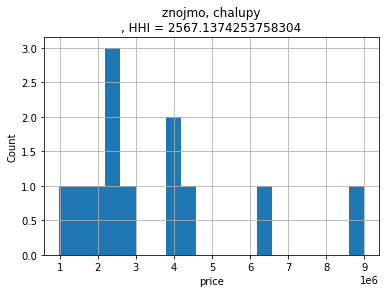

In [47]:
marketDF = marketDF.reset_index()
marketDF
for index, row in marketDF.iterrows():     
    data = df.loc[(df['id'] == row['Region']) & (df['HouseType'] == row['House Type']), ['price','companyName']]
    data['price'].hist(bins=20)
    plt.xlabel('price')
    plt.ylabel('Count')
    plt.title(f'{row["Name"]}, {row["House Type"]}, HHI = {row["HHI"]}')
    plt.show()
    
    
    
    totalValueSeries = data.groupby('companyName')['price'].sum().sort_values(ascending=False)
    

Let's say top 5 companies merge into one. (how it may effect all the market)

## Below I will transform various features to make them usable for further analysis

### 1. "Floor" variable: 

In [48]:
df['The floor'].unique()

array(['2', '3', nan, '3 včetně 1 podzemního', '4 včetně 1 podzemního',
       '5 včetně 1 podzemního', '1', '2 včetně 1 podzemního',
       '1 včetně 1 podzemního', '2. podlaží z celkem 2', '4',
       '4 včetně 2 podzemních', '1. podlaží z celkem 2',
       '3. podlaží z celkem 3',
       '1. podlaží z celkem 4 včetně 1 podzemního',
       '4. podlaží z celkem 4', '1. podlaží z celkem 3', '5',
       '1. podlaží z celkem 1',
       '1. podlaží z celkem 3 včetně 1 podzemního', '3. podlaží',
       '1. podlaží', '2. podlaží', '3 včetně 2 podzemních',
       '2 včetně 2 podzemních', '2. podlaží z celkem 1', '1 podzemní',
       '5 včetně 2 podzemních', '3. podlaží z celkem 2',
       '1. podlaží z celkem 2 včetně 1 podzemního',
       '1. podlaží z celkem 1 včetně 1 podzemního',
       '2. podlaží z celkem 4 včetně 2 podzemních',
       '2. podlaží z celkem 3 včetně 1 podzemního',
       '1 včetně 3 podzemních', '1. podlaží z celkem 4',
       '3 underground_floors_n', '4 včetně 3 podze

In [49]:
print('Percentage of rows with non-missing "The Floor" variable: {}'.format(percentageMissing('The floor')))

Percentage of rows with non-missing "The Floor" variable: 22.861


Users of the site "Srealty" do not use the field "Podlaži" in a consistent and predictable manner. Those who sell single-family homes use this variable to indicate the number of floors their property has, those who live in flats - the floor their flat is located.

### 2. Build-up area, Usable area, Floor Area, Land Area, Garden Area variables

In [50]:
def extractInt(string):
    charList = []
    for c in string:
        if c.isdigit():
            charList.append(c)
        else:
            break
    return int("".join(charList))

featureList = ['Built-up area', 'Usable area', 'Floor area', 'Land area', 'Garden area']
featuresModified = df.loc[:,featureList].applymap(extractInt, na_action='ignore')

for feature in featureList:
    df[feature] = featuresModified[feature].values
print(df.loc[:,featureList])

       Built-up area  Usable area  Floor area  Land area  Garden area
0                NaN          196         NaN      681.0          NaN
1               73.0          150         NaN      356.0          NaN
2              130.0          230         NaN      977.0        806.0
3                NaN          300         NaN    11600.0          NaN
4                NaN          675         NaN     1004.0          NaN
...              ...          ...         ...        ...          ...
15544          222.0          166         NaN      691.0          NaN
15545           25.0           31         NaN      100.0          NaN
15546            NaN          101         NaN     1642.0          NaN
15550          145.0          112         NaN        1.0          NaN
15551          218.0          630       831.0     1050.0          NaN

[13862 rows x 5 columns]


<AxesSubplot:>

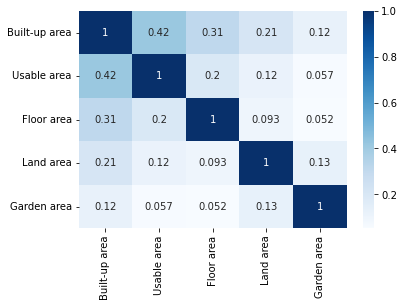

In [51]:
corr = df.loc[:,featureList].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

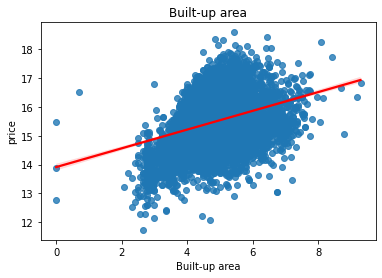

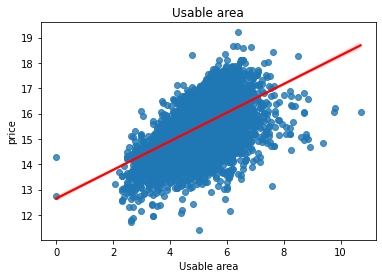

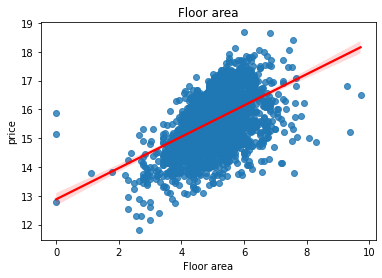

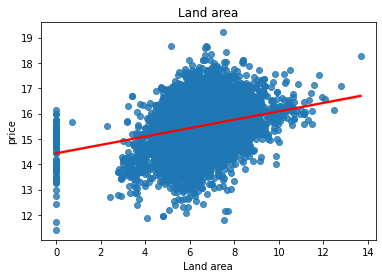

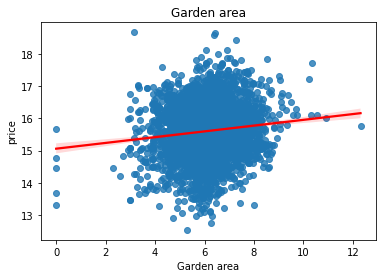

In [52]:
for feature in featureList:
    data = df.copy()
    data[feature] = np.log(data[feature])
    data['price'] = np.log(data['price'])
    sns.regplot(x=data[feature], y=data['price'], line_kws={"color": "red"})
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.title(feature)
    plt.show()

### 3. "Store" variable.

In [53]:
print('Percentage of rows with non-missing "Store" variable: {}'.format(percentageMissing('Store')))

Percentage of rows with non-missing "Store" variable: 64.724


In [54]:
df['Storage area'] = df['Store'].apply(lambda x: x if x != '1' else '0') # 0 will mean unknown
df['Storage area'] = df['Storage area'].str.replace(r'\s.*', '', regex=True)
df['Store'] = df['Store'].notnull().astype('int')

In [55]:
print(df['Store'].head())

0    0
1    1
2    0
3    0
4    0
Name: Store, dtype: int64


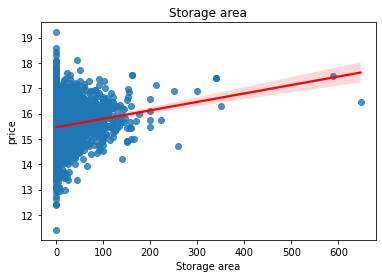

In [56]:
sns.regplot(x=pd.to_numeric(df['Storage area'], errors='coerce'), y=data['price'], line_kws={"color": "red"})
plt.xlabel('Storage area')
plt.ylabel('price')
plt.title('Storage area')
plt.show()

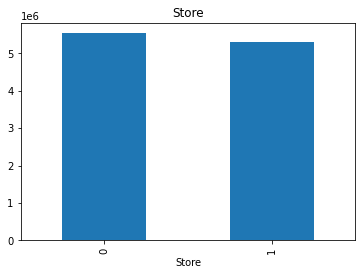

In [57]:
df.groupby('Store')['price'].median().plot.bar()
plt.title('Store')
plt.show()

Variable "Store" will indicate if the property has a storage unit. "Storage area" will denote the area of that storage unit if provided.

### 4. Energy efficiency of the building variable

In [58]:
df['Energy efficiency of the building'] = df['Energy efficiency of the building'].map(lambda x: x[6], na_action='ignore')
print(df['Energy efficiency of the building'])

0          C
1          G
2          G
3          F
4        NaN
        ... 
15544      G
15545    NaN
15546      G
15550      A
15551      G
Name: Energy efficiency of the building, Length: 13862, dtype: object


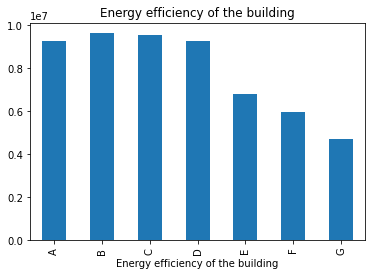

In [59]:
df.groupby('Energy efficiency of the building')['price'].median().plot.bar()
plt.title('Energy efficiency of the building')
plt.show()

### 5. Note on price variable

In [60]:
len(df['Note on price'].unique())

2186

In [61]:
print('Percentage of rows with non-missing "Note on price" variable: {}'.format(percentageMissing('Note on price')))

Percentage of rows with non-missing "Note on price" variable: 46.422


In [62]:
notesDict = Counter()
notesList = df['Note on price'].tolist()
for note in notesList:
    if pd.isna(note):
        continue
    notesDict.update([string.lower().lstrip() for string in re.split(',|;|/.', note)])
print(notesDict)

Counter({'včetně provize': 1489, 'včetně právního servisu': 1306, 'v případě více zájemců může rk využít pro výběr kupujícího formu aukce.': 1293, 'včetně poplatků': 664, 'včetně dph': 561, 'cena k jednání': 379, '+ provize rk': 252, 'včetně provize rk': 206, 'včetně provize a právního servisu': 154, 'včetně provize a právních služeb': 75, 'včetně provize rk a právního servisu': 69, 'cena včetně provize a právního servisu': 61, 'cena včetně provize rk': 57, 'cena včetně 1% provize': 48, 'včetně právního servisu a provize rk': 44, 'cena včetně provize': 41, 'na klíč': 40, 'vč. zákl. desky a dph': 39, '+ provize': 39, 'bez poplatků': 35, 'včetně provize rk a právních služeb': 31, 'vč. provize rk': 30, 'konečná cena': 29, 'neplatíte provizi': 29, 'advokátní úschovy': 28, 'vč. provize a právního servisu': 27, 'vč. provize a právních služeb': 27, 'k jednání': 26, 'vč. provize': 26, 'cena včetně provize a právních služeb': 26, 'právního servisu': 23, 'kupní cena včetně provize zprostředkovat

The dictionary above sorts the types of notes found in 'Note on price' variable by frequency of occurance.

In [63]:
df['Note on price'].fillna('Nothing', inplace=True)
df.loc[df['Note on price'].str.contains('poplatků', re.IGNORECASE), ['Note on price']]

Note on price
8                      včetně DPH, včetně poplatků, včetně provize, včetně právního servisu
10     včetně DPH, včetně poplatků, včetně provize, včetně právního servisu, cena k jednání
32                 včetně poplatků, včetně provize, včetně právního servisu, cena k jednání
154                                                               včetně veškerých poplatků
188                včetně poplatků, včetně provize, včetně právního servisu, cena k jednání
...                                                                                     ...
15395                              včetně poplatků, včetně provize, včetně právního servisu
15415                              včetně poplatků, včetně provize, včetně právního servisu
15418                              včetně poplatků, včetně provize, včetně právního servisu
15422                                                Uvedená cena bez provize RK a poplatků
15466                                               Včetně právních služeb a všech poplatků

[907 rows x 1 columns]

Next I will try to extract from the 'Note on price' variable the information about whether the house price includes comission, legal fees, vat, fees and if the price is negotiable.

In [64]:
def followsPattern(text, pattern):
        if re.search(pattern, text.lower().lstrip()):
            return True
        else:
            return False

notelist = ['provize', 'právního', 'dph', 'poplatků']
patternList = []

for note in notelist:
    patternList.append(re.compile('.*(včetně|\+)\s?.*{}.*'.format(note)))
patternList.append(re.compile('.*cena k jednání'))
notelist.append('cena k jednání')

for note,patternToFollow in zip(notelist,patternList):
    df[note] = df.loc[df['Note on price'].apply(followsPattern, pattern=patternToFollow),'Note on price'].map(lambda x: 'True', na_action='ignore')

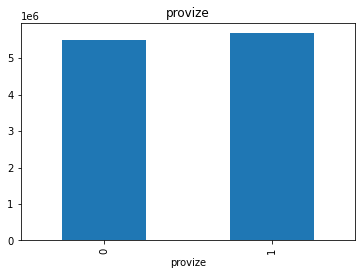

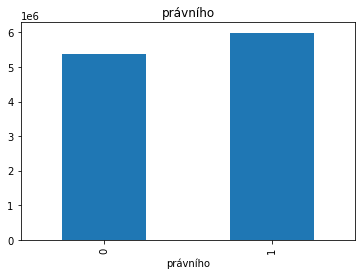

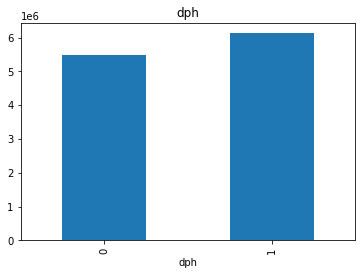

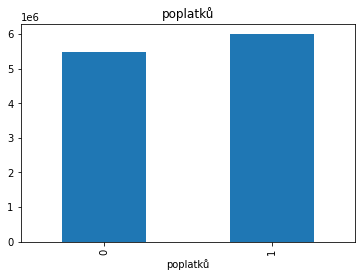

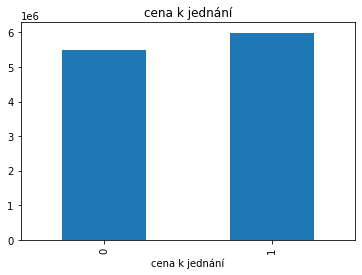

In [65]:
for feature in notelist:
    data = df.copy()
    data[feature] = np.where(data[feature].notnull(), 1, 0)
    data.groupby(feature)['price'].median().plot.bar()
    plt.title(feature)
    plt.show()

The interesting part here is that the houses where the price is negotiable (cena k jendnani) cost more than those that do not indicate the possibility of negotiation. 

### 6. "Lift" variable:

In [66]:
df.groupby('Lift')['Index'].count()

Lift
0.0    4459
1.0      30
Name: Index, dtype: int64

In [67]:
df['Lift'].count()/len(df.axes[0])

0.32383494445245997

Find how much different are the houses with 'lift = 1' from the median in term of price.

In [68]:
df.loc[df['Lift'] == 1.0, ['price']].describe()

price
count  3.000000e+01
mean   2.382750e+07
std    2.931383e+07
min    2.286000e+06
25%    5.237500e+06
50%    1.225000e+07
75%    2.687500e+07
max    1.290000e+08

In [69]:
# df.loc[df.education == '9th', 'education'].count()
df.loc[df['Lift'] == 1, 'Index'].count()

30

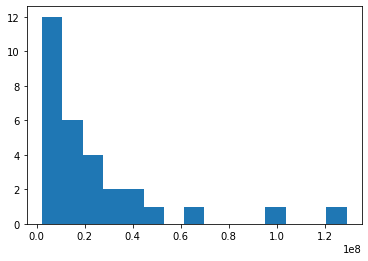

Median price for all properties is: 7387585
Median price for all properties with lift is: 23827500
p-value for t-test: [3.31135772e-34]


In [70]:
dataWithLift = df.loc[df['Lift'] == 1.0, ['price']]
plt.hist(dataWithLift, bins=15)
plt.show()

print('Median price for all properties is: {}'.format(round(df['price'].mean())))
print('Median price for all properties with lift is: {}'.format(round(dataWithLift['price'].mean())))

# if the sample size is larger than 30, use Z-test.
if df.loc[df['Lift'] == 1, 'Index'].count() <= 30:
    stat, p = ttest_ind(dataWithLift, df['price'])
    print('p-value for t-test: {}'.format(p))
else:
    stat, p = ztest(dataWithLift, df['price']) 
    print('p-value for z-test: {}'.format(p))

Given the small p-value the difference between the means are statistically signifficant. 

In [71]:
print(df['Electricity'].unique())

['230V' '230V, 400V' nan '400V' '120V, 230V, 400V' '120V' '120V, 230V'
 '120V, 400V'
 '<selenium.webdriver.remote.webelement.WebElement (session="7c904ca5a3622d98708b8a213b3d0a79", element="914904bf-417f-4d88-b0c5-d8661c142d11")>'
 '230V,']


## Housing costs

In [72]:
df.loc[pd.notna(df['Housing costs']),'Housing costs']

42                                                                   6400
44       po navýšení plyn 2800 kč, elektřina 2100 Kč, ochranka PCO 600 Kč
196                                                                 12000
209                                                                 10000
233                                                            7 000,- Kč
                                       ...                               
15337                                                                3000
15445                                                               6 800
15450                                                                   0
15455                                                                4166
15473                                                                4000
Name: Housing costs, Length: 459, dtype: object